In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB         
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.stem.porter import PorterStemmer
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection

# Objective:
### To use indexed Medical Subject Headings (MeSH) in MEDLINE citations and explore associations between Zika Virus Infections and U.S. indexed in the citations

# Visualization:
### Epidemiology of Zika Virus Infection

In [2]:
# Selection of relevant MeSH Terms: to obtain list with Geographic Locations terms from MeSH ASCII file and Zika Virus Infection search terms 
relevant_terms = []

# Downloaded MeSH ASCII formathttps://www.nlm.nih.gov/databases/download/mesh.html
fp = open('./MH Descriptor 2019.txt') 
line = " "
err_count = 0
val_count = 0
line_count = 0
while line != '':                  # While loop to extract only the terms that have MN = 
    try:
        while "MH" not in line:
            line = fp.readline()
            line_count += 1       
        
        MH = line[5:-1]
        while "MN" not in line:
            line = fp.readline()
            line_count += 1

        has_correct_MN = False
        while "MN" in line:
            if "Z01.107.567.875." in line:
                has_correct_MN = True
            line = fp.readline()
            line_count += 1

        if has_correct_MN:
            val_count += 1
            relevant_terms.append(MH)

        while "*NEWRECORD" not in line and line != '':
            line = fp.readline()
            line_count += 1
    except:
        err_count += 1
        line = " "
        while "*NEWRECORD" not in line and line != '':
            line = fp.readline()
            line_count += 1
print('Complete', val_count, err_count) # Extracted 401 Geo Locations Terms and added to relevant_terms
fp.close()

Complete 68 4


In [3]:
zika_df = pd.read_csv('./zika_inf_data.csv') # Read in PubMed Search Results obtained using BioPython
zika_df.head(5) # Data needs cleaning,  MeSH_Terms column has the data

Unnamed: 0      PMID                                            Journal  \
0           0  28511272               U.S. Army Medical Department journal   
1           1  28722594  The American journal of tropical medicine and ...   
2           2  29723166        MMWR. Morbidity and mortality weekly report   
3           3  28300974                          Cadernos de saude publica   
4           4  26898855                           Lancet (London, England)   

                                    PT  \
0                  ['Journal Article']   
1  ['Case Reports', 'Journal Article']   
2                  ['Journal Article']   
3                  ['Journal Article']   
4                           ['Letter']   

                                               Title  \
0  A location-specific spreadsheet for estimating...   
1  Fatal Leptospira spp./Zika Virus Coinfection-P...   
2  Vital Signs: Trends in Reported Vectorborne Di...   
3  From unplanned pregnancy to contraception: con...   
4  CDC guidelines for pregnant women during the Z...   

                                            Abstract  \
0  Local Zika virus transmission in the United St...   
1  Coinfection with pathogens that cause acute fe...   
2  INTRODUCTION: Vectorborne diseases are major c...   
3                                                NaN   
4                                                NaN   

                                          MeSH Terms  
0  ['Aedes/*virology', 'Animals', 'Ecosystem', 'E...  
1  ['Coinfection/epidemiology', 'Fatal Outcome', ...  
2  ['American Samoa/epidemiology', 'Animals', 'Ch...  
3  ['Abortion, Criminal', 'Adolescent', 'Brazil',...  
4  ['*Amniocentesis/adverse effects', 'Centers fo...

In [4]:
zika_df = zika_df.drop(columns=['Unnamed: 0', 'PMID', 'Journal', 'PT', 'Title', 'Abstract']) 
# Drop first column and all other columns, keep only MeSH column and index

In [5]:
zika_df.shape

(1637, 1)

In [6]:
zika_df.columns

Index(['MeSH Terms'], dtype='object')

In [7]:
# zika_df.mesh_terms contains the information we need to analyze
# Code for cleaning and extracting each relevant MeSH terms for each row e.g. row [0] only terms that are relevant are the Geo terms

zika_df['MeSH Terms'] = zika_df['MeSH Terms'].str.strip('[]') # Remove square brackets from MeSH terms
zika_df['MeSH Terms'] = zika_df['MeSH Terms'].str.replace('*', '') # Remove star to designate major MeSH terms
rel_terms = set(relevant_terms) # Convert relevant_terms to set for ease of finding intersection

final_terms = [] # Intitialize list of terms for analysis this will be a list of 8848 lists
final_simple_list = [] # Intitialize list of terms for analysis this will be a simple list of 8848 rows with relevant term(s) in each row 

for temp_mt in zika_df['MeSH Terms']:  # To extract each MeSH term from each row
    t = temp_mt.split('"') # To remove terms with double quotes (e.g. "Nurse's Role")
    if  len(t) > 2:
        temp_mt = t[0]+t[2][2:]
    elif len(t) == 2 and temp_mt[0] != '"':
        temp_mt = t[0]
    elif len(t) == 2:
        temp_mt = t[1][2:]
    
    end_mt= -1  # Initializing for start of search 
    mt_set = set() # Initializing an empty set to capture all the MeSH terms in each row, this set will be used to keep only the terms in the relevant_list (or rel_list)
    
    while (temp_mt.find("'", end_mt+1) != -1):   # Loop through until all terms have been found  

        start_mt = temp_mt.find("'", end_mt+1) # Find beginning and end quotes to extract MeSH term
        end_mt = temp_mt.find("'", start_mt+1)
    
        slash_pos = temp_mt[start_mt+1 : end_mt].find("/") # To delete subheadings when present
        if slash_pos != -1:
            truncated_mt= temp_mt[start_mt+1 : start_mt+slash_pos+1]
        else:
            truncated_mt= temp_mt[start_mt+1 : end_mt]     
        
        mt_set.add(truncated_mt) # mt_set contains all MeSH terms for the row
        
    intersect = mt_set & rel_terms # Keeps only the MeSH terms from row that are relevant_terms 
    if len(intersect) > 0:
        final_terms.append([term.replace(' ','_') for term in intersect])
        final_simple_list.append(' '.join(final_terms[-1])) # Space separated
    else:
        final_terms.append([])
        final_simple_list.append([])
    # For every term which is in both relevant terms and mt_set, replace spaces with underscores so that CountVectorizer does not split the term up into words
    # add to final_terms list

final_terms[0:10] # List of lists for each PMID
final_simple_list[:10] # Single list of MeSH terms in each row

[[], [], [], [], [], [], 'Florida', [], [], []]

In [8]:
# Use CountVectorizer to select terms with frequency of at least 1 after trying different numbers
disease_set = ['Zika_Virus_Infection']
filtered_model = []
for item in final_terms:
      if set(item).issubset(set(disease_set))==False:
#    if set(item) not in (set(disease_set)):
#       filtered_model.append(item)
        filtered_model.append(' '.join(item)) 
    
def csv_analyzer(s):
    "split on space" 
    return [term for term in s.split()]    
vect = CountVectorizer(analyzer=csv_analyzer, min_df=1) 
F = filtered_model
F1 = vect.fit_transform(F)

fmf = pd.DataFrame(vect.fit_transform(filtered_model).toarray(), columns=vect.get_feature_names())
fmf.shape
fmf.head(5)

California  Colorado  District_of_Columbia  Florida  Georgia  Hawaii  \
0           0         0                     0        1        0       0   
1           0         0                     0        1        0       0   
2           0         0                     0        1        0       0   
3           0         0                     0        0        0       0   
4           0         0                     0        1        0       0   

   Los_Angeles  Maryland  Massachusetts  Michigan  ...  New_York_City  \
0            0         0              0         0  ...              0   
1            0         0              0         0  ...              0   
2            0         0              0         0  ...              0   
3            0         0              1         0  ...              0   
4            0         0              0         0  ...              0   

   North_Carolina  North_Dakota  Ohio  Southeastern_United_States  Tennessee  \
0               0             0     0                           0          0   
1               0             0     0                           0          0   
2               0             0     0                           0          0   
3               0             0     0                           0          0   
4               0             0     0                           0          0   

   Texas  Utah  Virginia  Wisconsin  
0      0     0         0          0  
1      0     0         0          0  
2      0     0         0          0  
3      0     0         0          0  
4      1     0         0          1  

[5 rows x 23 columns]

In [9]:
vect = CountVectorizer(analyzer=csv_analyzer, min_df=1, lowercase=False) 
fmf = pd.DataFrame(vect.fit_transform(filtered_model).toarray(), columns=vect.get_feature_names())
df = vect.fit_transform(filtered_model).toarray().sum(axis=0)
z_americas_freq = pd.DataFrame(df.reshape(1, 23), columns=vect.get_feature_names())
print(z_americas_freq)

   California  Colorado  District_of_Columbia  Florida  Georgia  Hawaii  \
0           4         2                     6       41        4       2   

   Los_Angeles  Maryland  Massachusetts  Michigan  ...  New_York_City  \
0            1         1              4         2  ...             17   

   North_Carolina  North_Dakota  Ohio  Southeastern_United_States  Tennessee  \
0               1             1     1                           2          1   

   Texas  Utah  Virginia  Wisconsin  
0     18     3         1          1  

[1 rows x 23 columns]


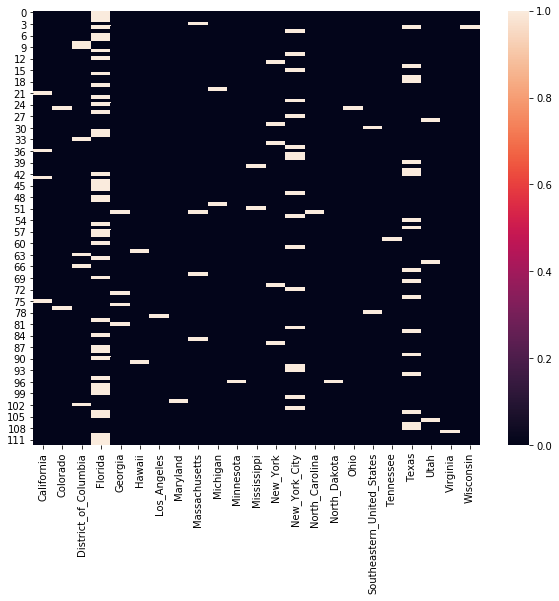

In [10]:
# Plot heatmap, this plots map of each 23 Geo terms in each row of the Dataframe
plt.figure(figsize=(10,8))
sns.heatmap(fmf);

[Text(0, 0, 'California'),
 Text(0, 0, 'Colorado'),
 Text(0, 0, 'District_of_Columbia'),
 Text(0, 0, 'Florida'),
 Text(0, 0, 'Georgia'),
 Text(0, 0, 'Hawaii'),
 Text(0, 0, 'Los_Angeles'),
 Text(0, 0, 'Maryland'),
 Text(0, 0, 'Massachusetts'),
 Text(0, 0, 'Michigan'),
 Text(0, 0, 'Minnesota'),
 Text(0, 0, 'Mississippi'),
 Text(0, 0, 'New_York'),
 Text(0, 0, 'New_York_City'),
 Text(0, 0, 'North_Carolina'),
 Text(0, 0, 'North_Dakota'),
 Text(0, 0, 'Ohio'),
 Text(0, 0, 'Southeastern_United_States'),
 Text(0, 0, 'Tennessee'),
 Text(0, 0, 'Texas'),
 Text(0, 0, 'Utah'),
 Text(0, 0, 'Virginia'),
 Text(0, 0, 'Wisconsin')]

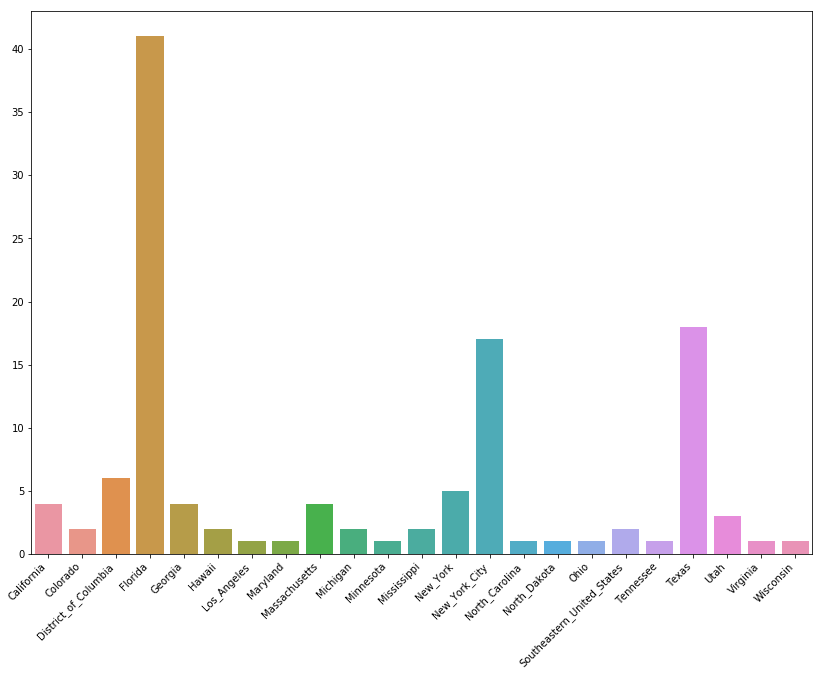

In [11]:
# Bar plot
plt.figure(figsize=(14,10))
ax = sns.barplot(data=z_americas_freq)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

# Results and Conclusion: 
### Heat map and Bar chart of U.S. states (and some regions and cities) in the U.S. that had Zika Virus infection cases.